In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import nibabel as nib
import psutil
import cv2
%matplotlib inline

In [4]:
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates'
os.listdir(root_directory)

['JFRC_boo-to-syn_0_mean.nii',
 'kevin.nii',
 'syn_4_sharp.nii',
 'seed_syn_1_mean_0810-to-diego.nii',
 'diego.nii',
 'syn_0_mean-to-kevin.nii',
 'brain_sharp_test.nii',
 'syn_0_mean-to-IBNWB.nii',
 'seed_syn_1_mean_0810-to-IBNWB.nii',
 'syn_0_mean-to-JFRC.nii',
 'luke.nii',
 'test_001.nii',
 'diego.nrrd',
 'seed_syn_1_mean_0810-to-kevin.nii',
 'syn_0_mean-to-diego.nii',
 'JFRCtemplate2010.nii',
 'JFRC-to-syn_0_mean.nii',
 'IBNWB.nii',
 'syn_0_mean.nii',
 'seed_syn_1_mean_0810.nii',
 'IBNWB.nrrd']

In [249]:
brain_file = os.path.join(root_directory, 'luke.nii')
luke = np.array(nib.load(brain_file).get_data(), copy=True)#[:,:,:,0]

In [320]:
brain_file = os.path.join(root_directory, 'luke_edges.nii')
luke_edges = np.array(nib.load(brain_file).get_data(), copy=True)[:,:,:,0]

In [288]:
brain_file = os.path.join(root_directory, 'JFRCtemplate2010.nii')
jfrc = np.array(nib.load(brain_file).get_data(), copy=True)[:,:,:,0]
jfrc = jfrc[:,:,::-1]

In [101]:
brain_file = os.path.join(root_directory, 'JFRCtempate2010.mask130819_Original.nii')
mask = np.array(nib.load(brain_file).get_data(), copy=True)[:,:,:,0]

In [347]:
regions = {'PB': 6, 'FB': 26, 'MB1': 18, 'MB2': 65, 'MB3': 64,
           'MB4': 17, 'MB5': 19, 'MB6': 66, 'AOTU1': 79, 'AOTU2': 34}
new_mask = np.zeros(np.shape(mask))
for region in regions:
    new_mask[np.where(mask == regions[region])] = 1
    
new_mask_edges = []
for z in range(new_mask.shape[2]):
    out = cv2.Canny(np.uint8(new_mask[:,:,z]),0,1)
    new_mask_edges.append(out)
new_mask_edges = np.asarray(new_mask_edges)
new_mask_edges = np.moveaxis(new_mask_edges,0,-1)[:,:,::-1]

In [365]:
#wholebrain mask
new_mask = np.zeros(np.shape(mask))
new_mask[np.where(mask != 0)] = 1
new_mask = new_mask[:,:,::-1]   
    
new_mask_edges_2 = []
for z in range(new_mask.shape[2]):
    out = cv2.Canny(np.uint8(new_mask[:,:,z]),0,1)
    new_mask_edges_2.append(out)
new_mask_edges_2 = np.asarray(new_mask_edges_2)
new_mask_edges_2 = np.moveaxis(new_mask_edges_2,0,-1)

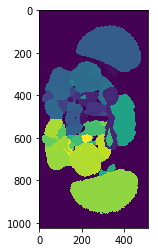

In [386]:
plt.imshow(mask[:,:,100])

In [393]:
#wholebrain mask
# new_mask = np.zeros(np.shape(mask))
# new_mask[np.where(mask != 0)] = 1
# new_mask = new_mask[:,:,::-1]   
    
edges_all_rois = []
for z in range(mask.shape[2]):
    out = cv2.Canny(np.uint8(mask[:,:,z]),0,1)
    edges_all_rois.append(out)
edges_all_rois = np.asarray(edges_all_rois)
edges_all_rois = np.moveaxis(edges_all_rois,0,-1)

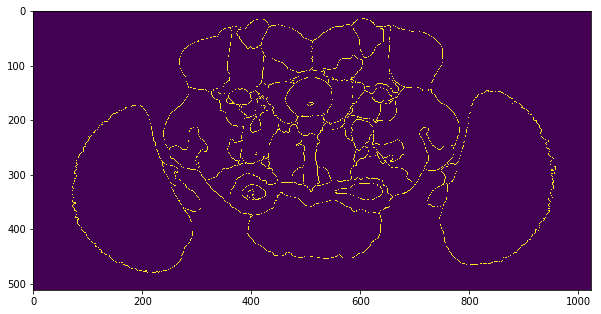

In [396]:
plt.figure(figsize=(10,10))
plt.imshow(edges_all_rois[:,:,100].T)

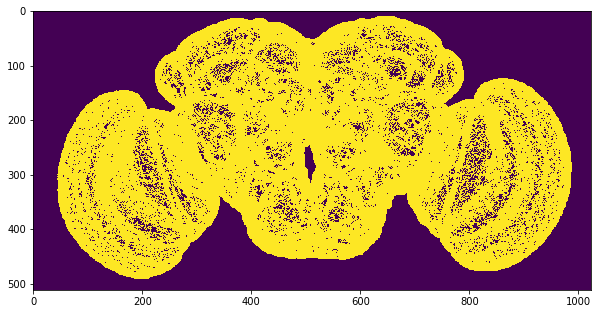

In [366]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(new_mask_edges_2,axis=-1).T)

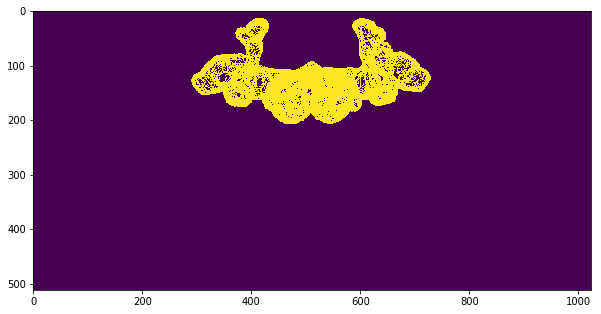

In [368]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(new_mask_edges,axis=-1).T)

In [369]:
new_mask_edges_all = new_mask_edges + new_mask_edges_2

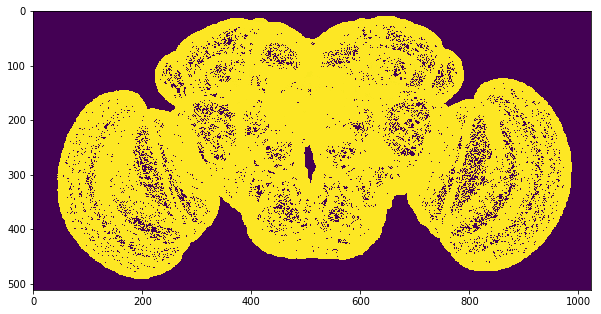

In [370]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(new_mask_edges_all,axis=-1).T)

In [417]:
new_luke = np.zeros(np.shape(luke))
new_luke[np.where(luke > .7)] = 1

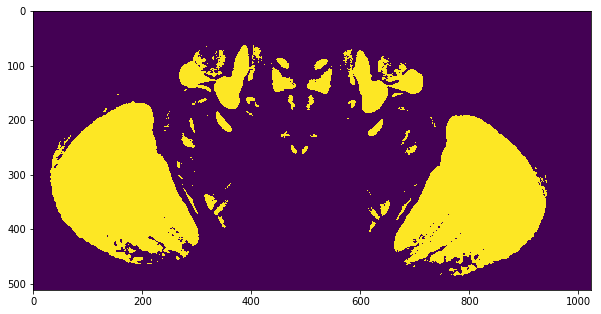

In [420]:
plt.figure(figsize=(10,10))
plt.imshow(new_luke[:,:,130].T)

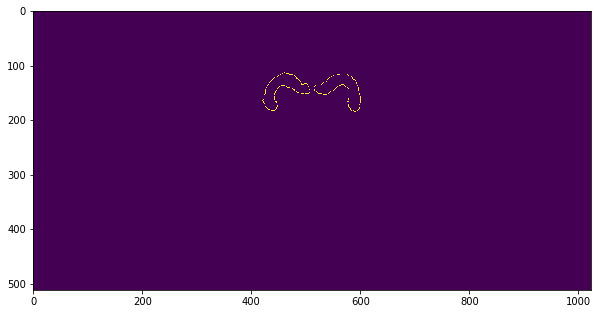

In [356]:
plt.figure(figsize=(10,10))
plt.imshow(new_mask_edges[:,:,40].T)

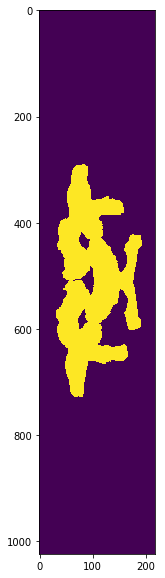

In [168]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(new_mask_edges,axis=2).T)

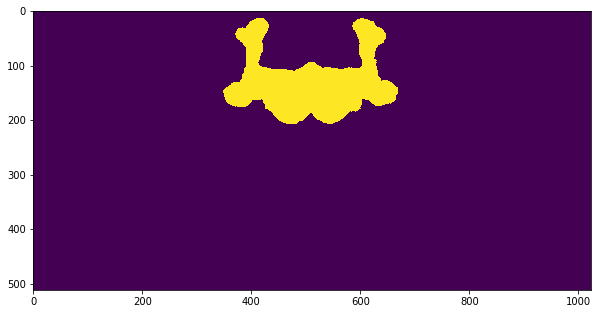

In [121]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(new_mask[:,:,:],axis=-1).T)

In [407]:
new_luke.shape

(1024, 512, 256)

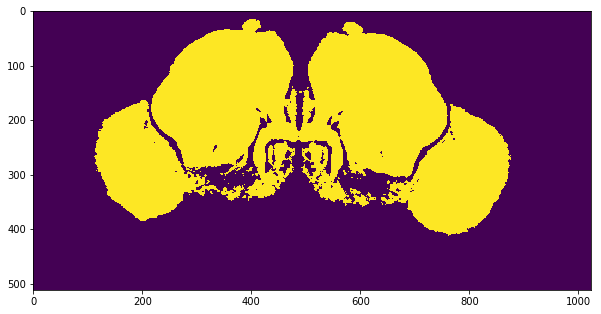

In [411]:
plt.figure(figsize=(10,10))
plt.imshow(new_luke[:,:,60].T)

In [412]:
master = ants.from_numpy(new_luke*100)
master.set_spacing((.65,.65,1))
master = ants.resample_image(master,(256,128,64),1,0)
slave = ants.from_numpy(new_mask)
slave.set_spacing((.62,.62,.62))
slave = ants.resample_image(slave,(256,128,64),1,0)

In [274]:
t0 = time.time()
slave2master = ants.registration(master,slave,type_of_transform='SyN')
print(time.time()-t0)

24.271464109420776


In [315]:
# now that we've first warped with the full mask,
# let's apply these warp params to the jfrc edges
# Then, warp this warped jfrc edges to luke edges

jfrc_edges = ants.from_numpy(new_mask_edges[:,:,::-1])
jfrc_edges.set_spacing((.62,.62,.62))
jfrc_edges = ants.resample_image(jfrc_edges,(256,128,64),1,0)

jfrc_edges_warped = ants.apply_transforms(master, jfrc_edges, slave2master['fwdtransforms'])

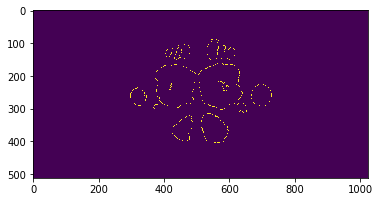

In [376]:
plt.imshow(new_mask_edges_all[:,:,180].T)

In [397]:
# now that we've first warped with the full mask,
# let's apply these warp params to the jfrc edges
# Then, warp this warped jfrc edges to luke edges

jfrc_edges = ants.from_numpy(edges_all_rois[:,:,::-1])
jfrc_edges.set_spacing((.62,.62,.62))
jfrc_edges = ants.resample_image(jfrc_edges,(256,128,64),1,0)

jfrc_edges_warped = ants.apply_transforms(master, jfrc_edges, slave2master['fwdtransforms'])

In [321]:
luke_edges_ants = ants.from_numpy(luke_edges*100)
luke_edges_ants.set_spacing((.65,.65,1))
luke_edges_ants = ants.resample_image(luke_edges_ants,(256,128,64),1,0)

In [398]:
t0 = time.time()
edges2edges = ants.registration(luke_edges_ants,jfrc_edges_warped,type_of_transform='SyN')
print(time.time()-t0)

21.203367710113525


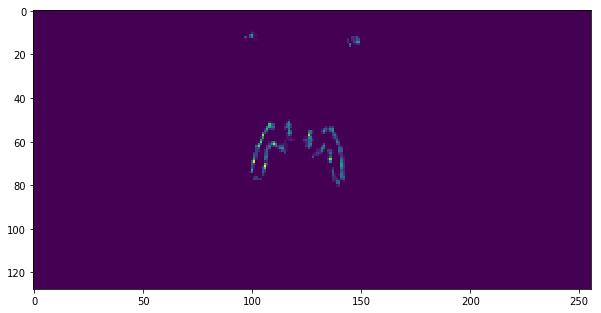

In [361]:
plt.figure(figsize=(10,10))
plt.imshow(jfrc_edges_warped.numpy()[:,:,10].T)

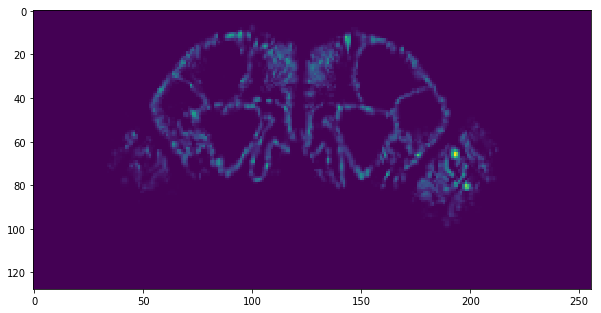

In [404]:
plt.figure(figsize=(10,10))
plt.imshow(edges2edges['warpedmovout'].numpy()[:,:,10].T)

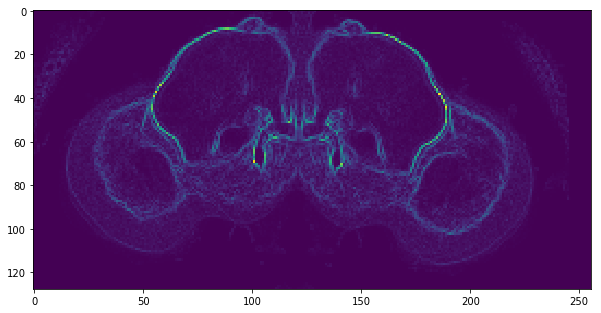

In [405]:
plt.figure(figsize=(10,10))
plt.imshow(luke_edges_ants[:,:,15].T)

In [406]:
buddy = ants.from_numpy(jfrc)
buddy.set_spacing((.62,.62,.62))
buddy = ants.resample_image(buddy,(256,128,64),1,0)

In [291]:
out = ants.apply_transforms(master, buddy, slave2master['fwdtransforms'])

In [ ]:
master = ants.from_numpy(luke*100)
master.set_spacing((.65,.65,1))
#master = ants.resample_image(master,(256,128,49),1,0)
slave = ants.from_numpy(new_mask)
slave.set_spacing((.62,.62,.62))

t0 = time.time()
slave2master = ants.registration(master,slave,type_of_transform='Affine')
print(time.time()-t0)

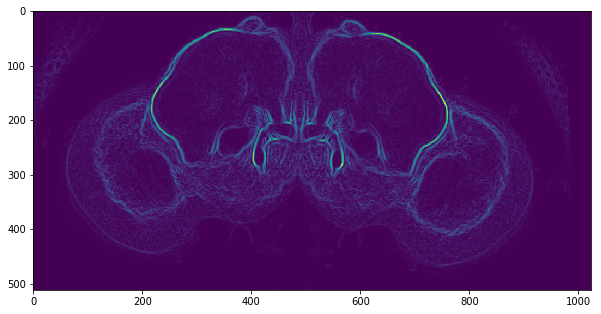

In [242]:
plt.figure(figsize=(10,10))
plt.imshow(luke[:,:,60].T)

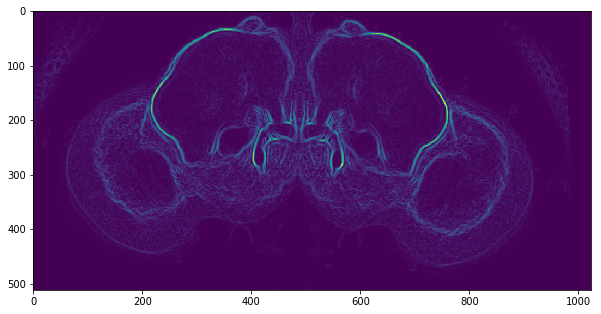

In [237]:
plt.figure(figsize=(10,10))
plt.imshow(master.numpy()[:,:,60].T)

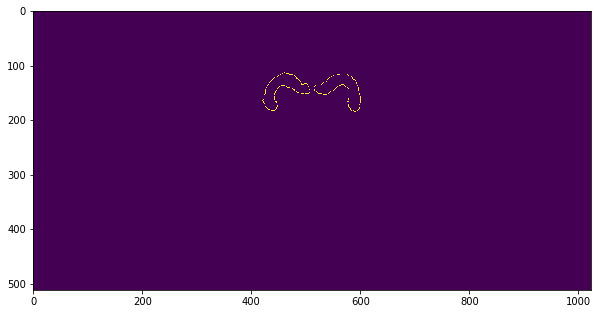

In [241]:
plt.figure(figsize=(10,10))
plt.imshow(slave.numpy()[:,:,40].T)

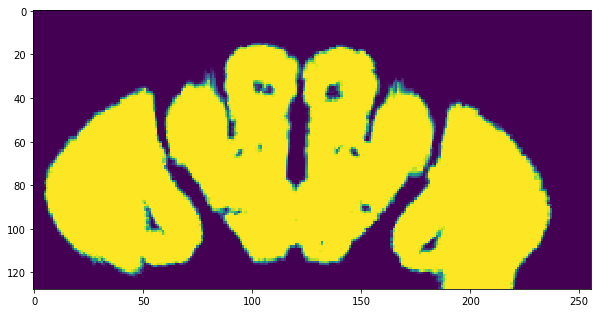

In [283]:
plt.figure(figsize=(10,10))
plt.imshow(slave2master['warpedmovout'][:,:,40].T)

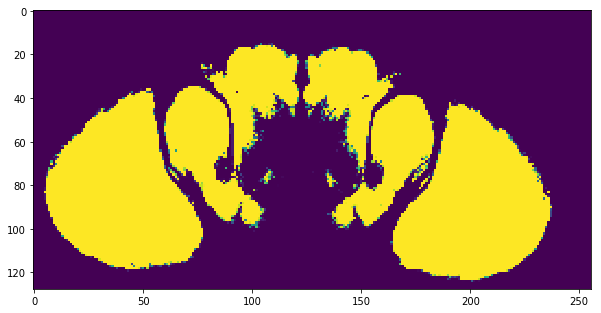

In [284]:
plt.figure(figsize=(10,10))
plt.imshow(master.numpy()[:,:,40].T)

In [299]:
test = ants.from_numpy(luke*100)
test.set_spacing((.65,.65,1))
test = ants.resample_image(test,(256,128,64),1,0)

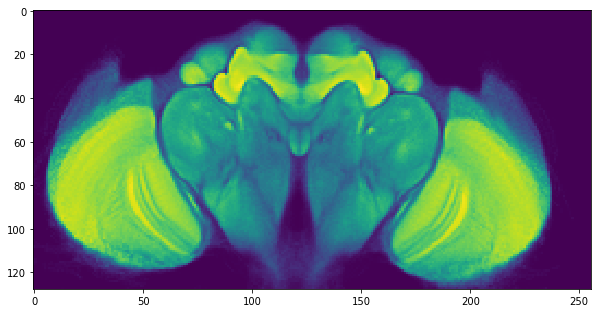

In [309]:
plt.figure(figsize=(10,10))
plt.imshow(test.numpy()[:,:,35].T)

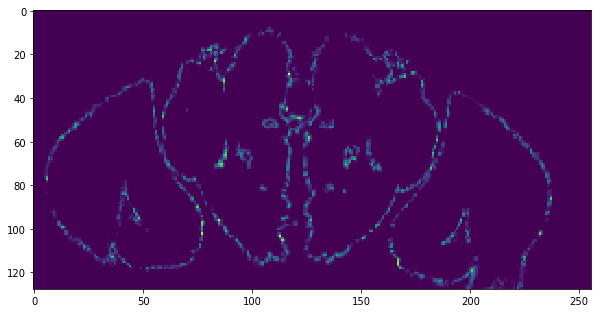

In [317]:
plt.figure(figsize=(10,10))
plt.imshow(jfrc_edges_warped.numpy()[:,:,35].T)

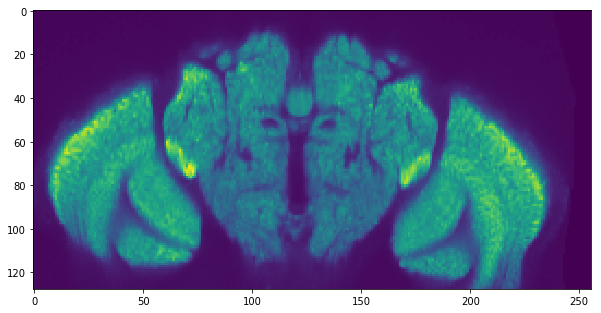

In [310]:
plt.figure(figsize=(10,10))
plt.imshow(out.numpy()[:,:,35].T)

In [297]:
plt.figure(figsize=(10,10))
plt.imshow(slave2master['warpedmovout'][:,:,100].T)

IndexError: index 100 is out of bounds for axis 2 with size 64

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(luke[:,:,100].T)

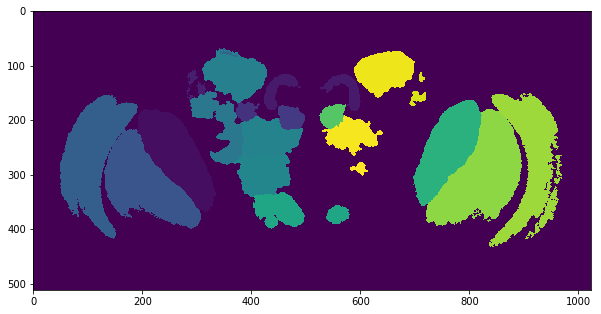

In [104]:
plt.figure(figsize=(10,10))
plt.imshow(mask[:,:,180].T)

In [ ]:


plt.figure(figsize=(10,10))
plt.imshow(mask[:,:,180].T)

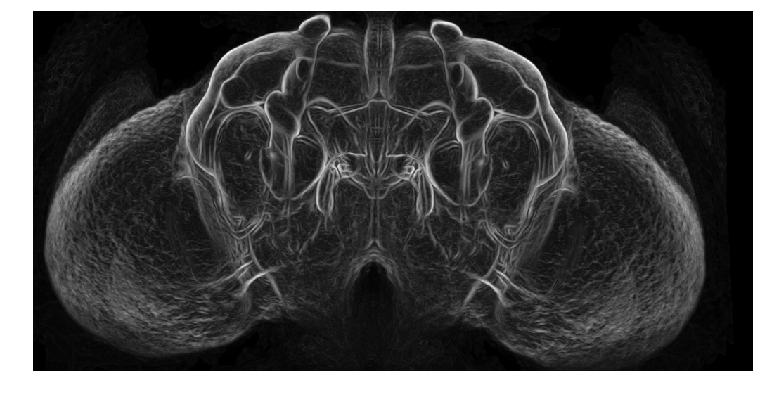

In [140]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([1,1,1,1])
ax.imshow(np.max(luke,axis=-1).T,cmap='gray')
ax.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')